In [117]:
from __future__ import annotations
import pandas as pd
from ipyleaflet import Map, Marker, AntPath
from pathlib import Path
from datetime import datetime
from datetime import date
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class TrackView:
    _df: pd.DataFrame
    _start: pd.Timestamp
    _end: pd.Timestamp
    _df_selected: pd.DataFrame
    _map: Map
    _marker: Marker
    _ant_path: AntPath
    _start_widget: widgets.DatePicker
    _end_widget: widgets.DatePicker

    def __init__(self, df: pd.DataFrame, default_window: int = 7200, default_zoom: int = 18):
        self._df = df
        self._end = df.iloc[-1]['timestamp']
        self._start = self._end - timedelta(seconds=default_window)
        self._df_selected = df[(self._start <= df['timestamp']) & (df['timestamp'] <= self._end)]
        # Map
        self.add_map(default_zoom)
        # Controls
        self.add_controls()
    
    def add_controls(self):
        self._start_widget = widgets.DatePicker(
            description='Starting Date',
            disabled=False
        )
        self._start_widget.observe(self.on_start_change, names='value')
        display(self._start_widget)
        self._end_widget = widgets.DatePicker(
            description='End Date',
            disabled=False
        )
        self._end_widget.observe(self.on_end_change, names='value')
        display(self._end_widget)

    def add_map(self, zoom: int):
        # Show Greenwich by default
        center=(51.4934, 0.0098)
        if len(self._df_selected.shape) > 0 and self._df_selected.shape[0] > 0:
            center = self._df_selected[['lat', 'lon']].iloc[-1].values.tolist()
        elif len(df.shape) > 0 and df.shape[0] > 0:
            center = df[['lat', 'lon']].iloc[-1].values.tolist()
        self._map = Map(center=center, zoom=zoom, scroll_wheel_zoom=True)
        self._marker = Marker(location=center, draggable=True)
        self._ant_path = AntPath(
            locations=self._df_selected[['lat', 'lon']].values.tolist(),
            dash_array=[1, 10],
            delay=1000,
            color='#7590ba',
            pulse_color='#3f6fba'
        )
        self._map.add_layer(self._ant_path)
        self._map.add_layer(self._marker)

    @staticmethod    
    def from_data(file_path: Path) -> TrackView:
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
        df.index = df['timestamp']
        return TrackView(df)
    
    def display(self) -> TrackView:
        display(self._map)
        return self
    
    def _update(self):
        if not self._df_selected.empty and self._df_selected.shape[0] > 0:
            # print(f'rows: {self._df_selected.shape[0]}')
            self._map.remove_layer(self._ant_path)
            self._ant_path = AntPath(
                locations=self._df_selected[['lat', 'lon']].values.tolist(),
                dash_array=[1, 10],
                delay=1000,
                color='#7590ba',
                pulse_color='#3f6fba'
            )
            self._map.add_layer(self._ant_path)
            self._map.remove_layer(self._marker)
            center = self._df_selected[['lat', 'lon']].iloc[-1].values.tolist()
            self._marker = Marker(center=center, draggable=True)
            self._map.add_layer(self._marker)
    
    def on_start_change(self, change):
        value = change['new']
        self._start = pd.Timestamp(value)
        self._df_selected = self._df[(self._start <= self._df['timestamp']) & (self._df['timestamp'] <= self._end)]
        self._update()


    def on_end_change(self, change):
        value = change['new']
        self._end = pd.Timestamp(value)
        self._df_selected = self._df[(self._start <= self._df['timestamp']) & (self._df['timestamp'] <= self._end)]
        self._update()

In [3]:
tv = TrackView.from_data(Path().absolute().parent / 'tests' / 'data.csv').display()

DatePicker(value=None, description='Starting Date')

DatePicker(value=None, description='End Date')

Map(center=[48.99505333, 8.39241333], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [10]:
def show_peaks(df: pd.DataFrame, threshold=50):
    x = df['speed'].values
    peaks,_ = find_peaks(x, height=threshold)
    plt.figure(figsize=(18, 6))
    plt.grid()
    plt.plot(x, lw=0.25)
    plt.plot(peaks, x[peaks], 'x')
    plt.hlines(threshold, 0, x.shape[0], colors='r', linestyle='--', lw=2)
    #
    return peaks

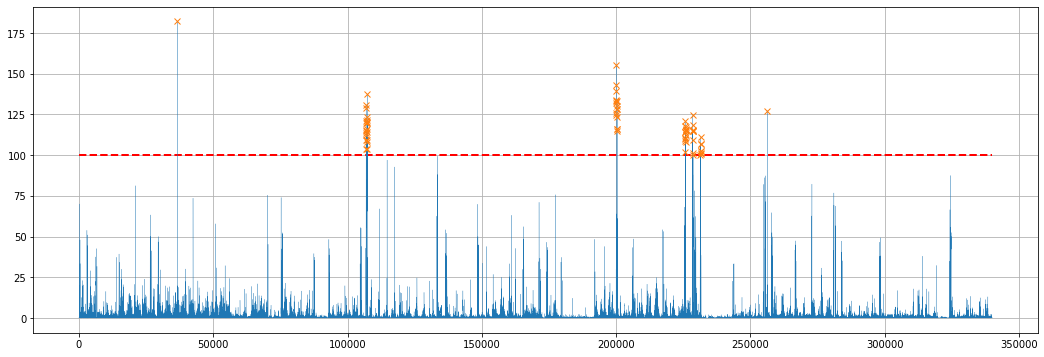

In [11]:
peaks = show_peaks(tv._df, threshold=100)

In [105]:
def show_peaks_table(df: pd.DataFrame, peaks: np.ndarray):
    df_peaks = df.iloc[peaks].copy()
    s = df_peaks['timestamp'].map(lambda x: x.date())
    df_peaks['date'] = s
    df_mean_speed = df_peaks.groupby('date').mean()
    print(df_mean_speed[['speed']])
    #
    print('\n'*2)
    print(df_peaks.to_string())

In [106]:
show_peaks_table(tv._df, peaks)

                 speed
date                  
2020-09-19  182.051600
2020-10-13  117.198265
2020-11-14  129.859925
2020-11-23  113.143613
2020-11-24  112.599533
2020-11-25  103.871737
2020-12-03  127.250900



                              timestamp        lat       lon     speed  direction        date
timestamp                                                                                    
2020-09-19 02:37:24 2020-09-19 02:37:24  48.999318  8.393278  182.0516          7  2020-09-19
2020-10-13 08:10:48 2020-10-13 08:10:48  49.002405  8.449863  112.2682         45  2020-10-13
2020-10-13 08:11:47 2020-10-13 08:11:47  49.015422  8.466202  120.8986         34  2020-10-13
2020-10-13 08:12:47 2020-10-13 08:12:47  49.030673  8.481187  129.0844         25  2020-10-13
2020-10-13 08:13:47 2020-10-13 08:13:47  49.047897  8.492818  130.9179         25  2020-10-13
2020-10-13 08:15:46 2020-10-13 08:15:46  49.078997  8.518083  113.7869         42  2020-10-13
2020-10-13 08:17:45 2020-10-13 08:17:4

In [154]:
def plot_day(df: pd.DataFrame):
    df_date = df.copy()
    df_date['date'] = df['timestamp'].map(lambda x: x.date())
    df_day = df_date[df_date['date'] == date(year=2020, month=10, day=13)]
    plt.figure(figsize=(20, 8))
    plt.grid()
    plt.plot(df_day['speed'])

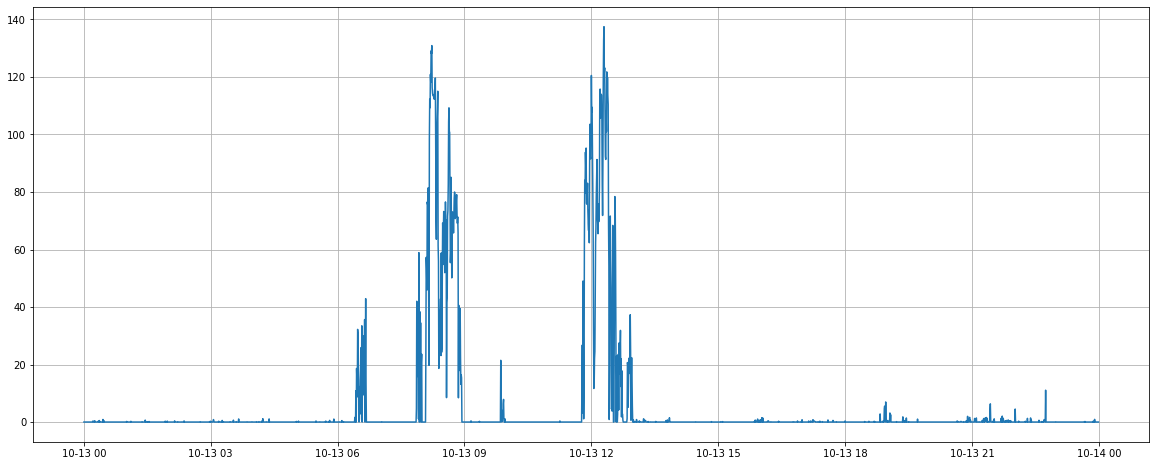

In [155]:
plot_day(tv._df)